Network Loss Memory Analysis - Isolation Forest Outlier Detection

📊 Processing Memory Utilization:
  NETLOSS: Cleaned 10 outliers
  BASELINE: Cleaned 10 outliers

📊 Processing Memory Cache:
  NETLOSS: Cleaned 10 outliers
  BASELINE: Cleaned 10 outliers

📊 Processing Memory Available:
  NETLOSS: Cleaned 10 outliers
  BASELINE: Cleaned 10 outliers

🔄 Analyzing Memory Utilization...


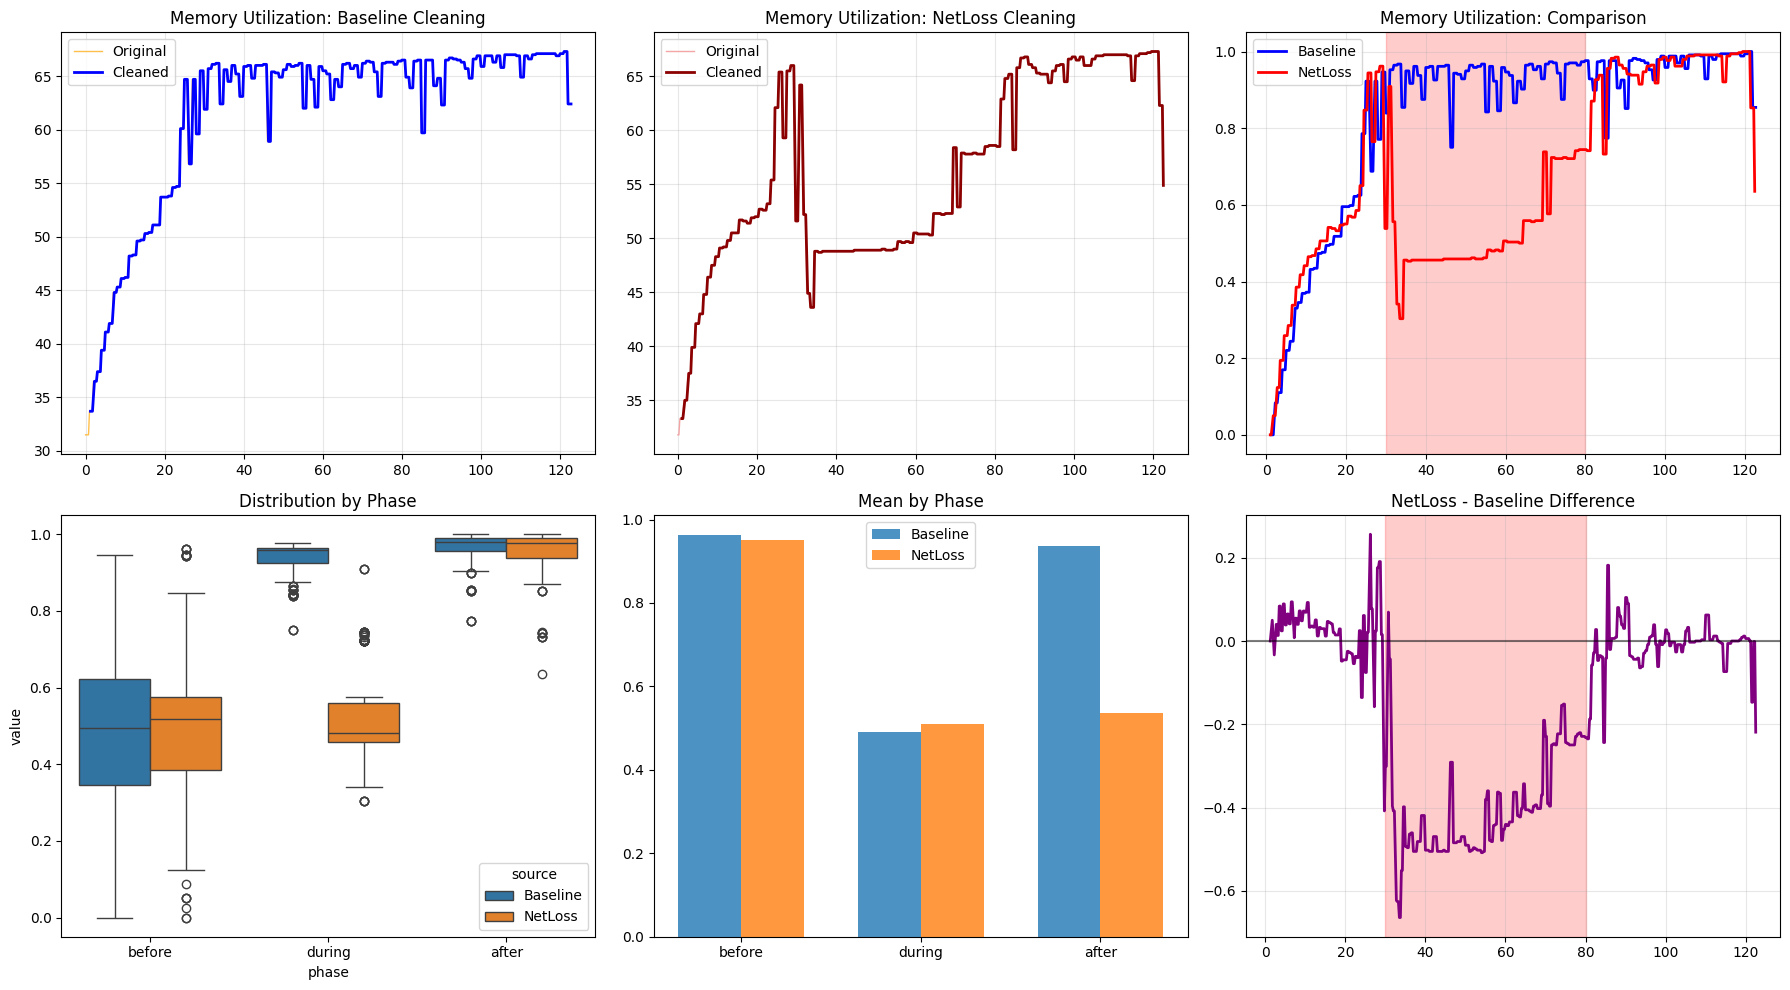


MEMORY UTILIZATION RESULTS:
BASELINE STATS BY PHASE:
          mean     std
phase                 
after   0.9625  0.0460
before  0.4917  0.2423
during  0.9360  0.0442

NETLOSS STATS BY PHASE:
          mean     std
phase                 
after   0.9508  0.0655
before  0.5096  0.2355
during  0.5359  0.1203

STATISTICAL TESTS:
  BEFORE: t=-0.57, p=0.5706 (NOT SIGNIFICANT)
  DURING: t=44.25, p=0.0000 (SIGNIFICANT)
  AFTER: t=1.91, p=0.0565 (NOT SIGNIFICANT)

IMPACT (% CHANGE):
  BEFORE: +3.6%
  DURING: -42.7%
  AFTER: -1.2%

🔄 Analyzing Memory Cache...


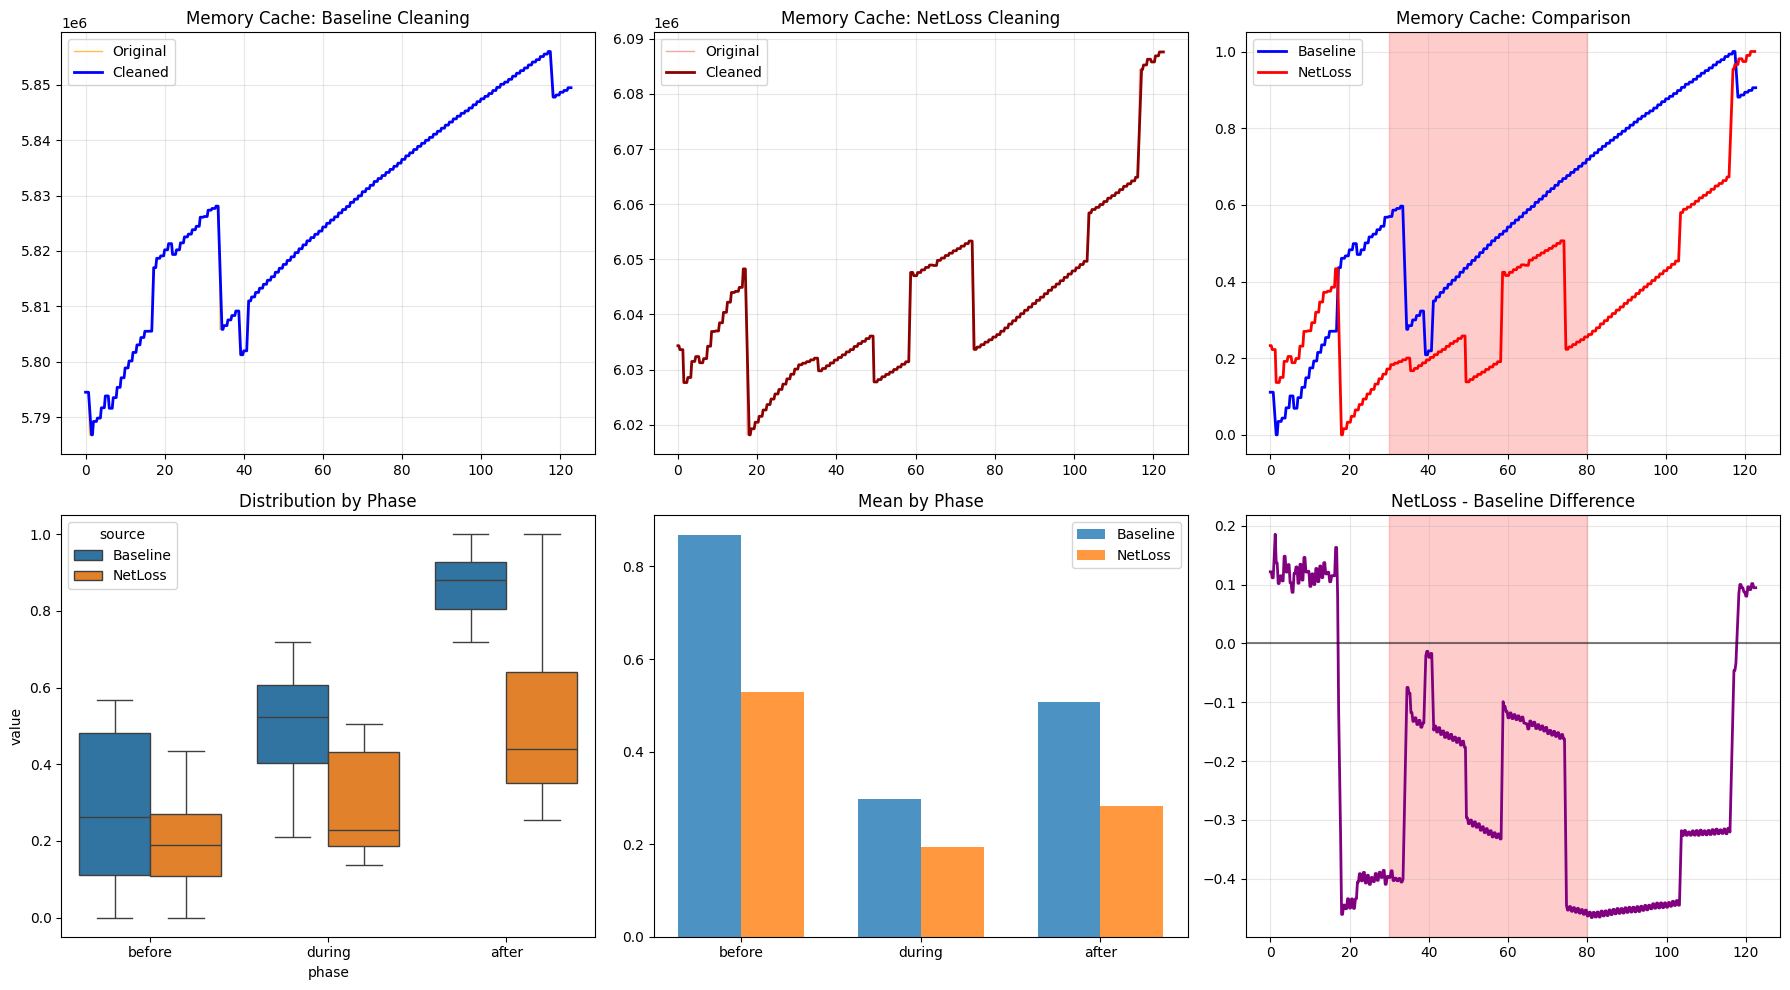


MEMORY CACHE RESULTS:
BASELINE STATS BY PHASE:
          mean     std
phase                 
after   0.8676  0.0781
before  0.2968  0.1884
during  0.5066  0.1328

NETLOSS STATS BY PHASE:
          mean     std
phase                 
after   0.5298  0.2241
before  0.1947  0.1127
during  0.2829  0.1245

STATISTICAL TESTS:
  BEFORE: t=5.09, p=0.0000 (SIGNIFICANT)
  DURING: t=17.43, p=0.0000 (SIGNIFICANT)
  AFTER: t=18.61, p=0.0000 (SIGNIFICANT)

IMPACT (% CHANGE):
  BEFORE: -34.4%
  DURING: -44.2%
  AFTER: -38.9%

🔄 Analyzing Memory Available...


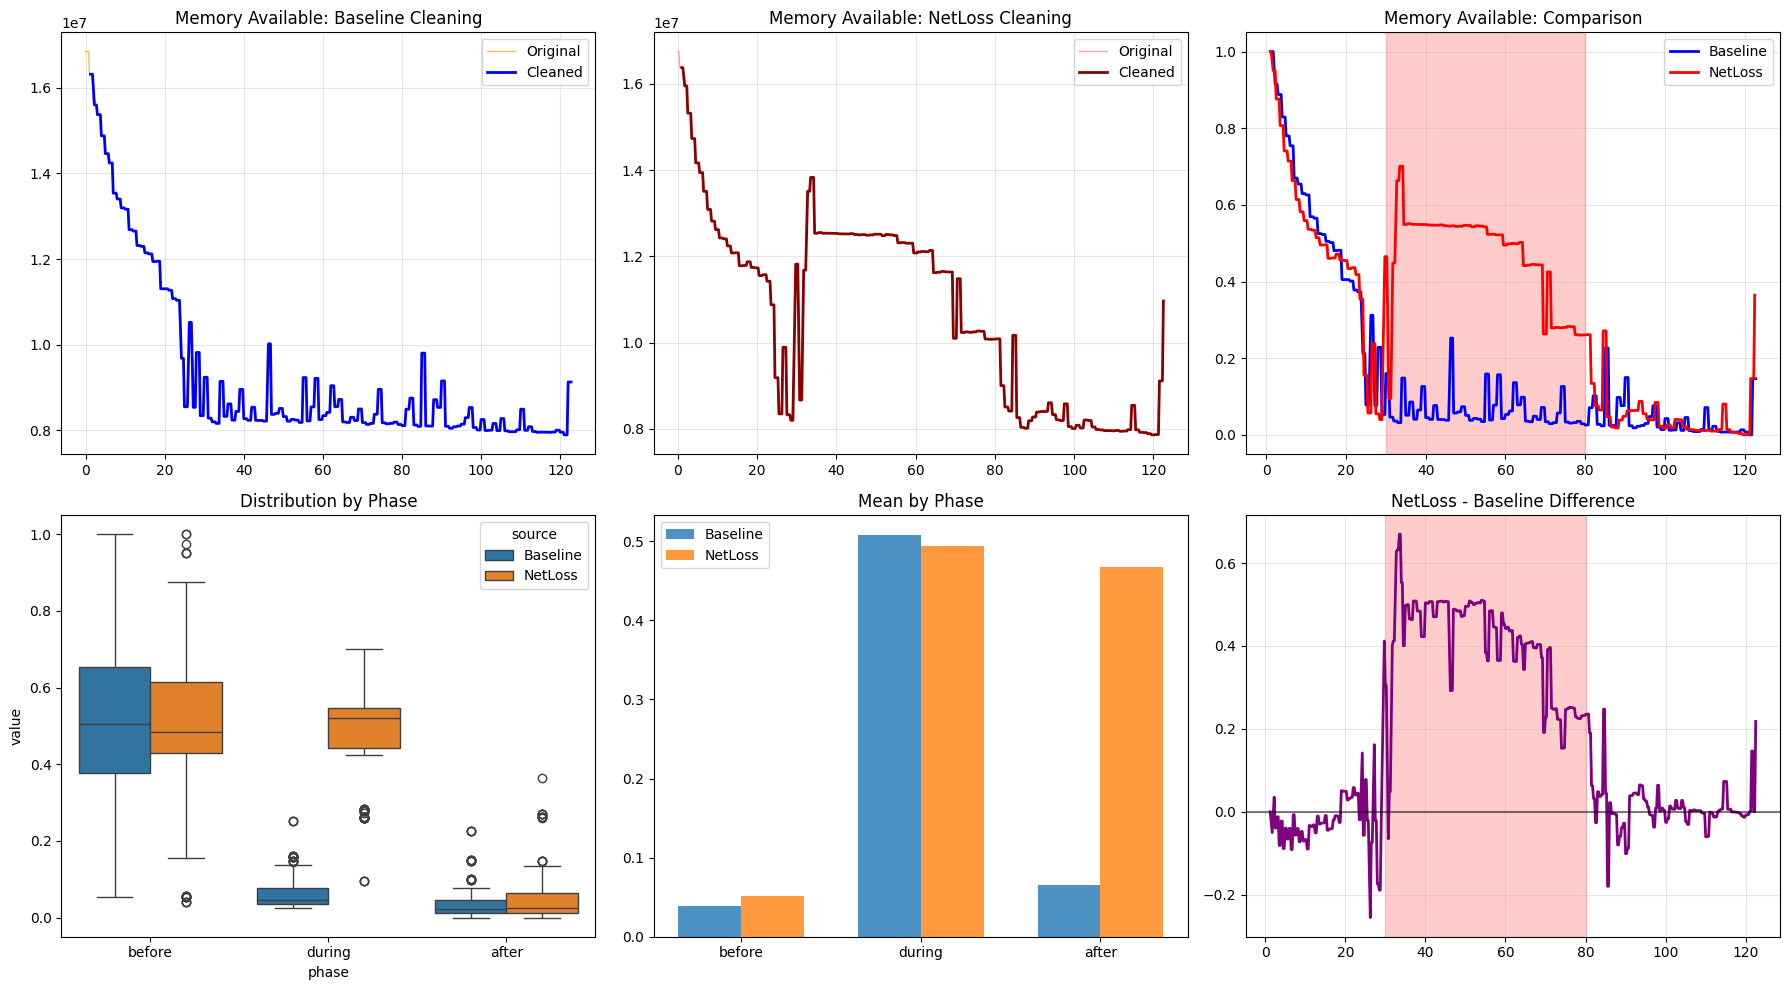


MEMORY AVAILABLE RESULTS:
BASELINE STATS BY PHASE:
          mean     std
phase                 
after   0.0382  0.0460
before  0.5077  0.2411
during  0.0650  0.0443

NETLOSS STATS BY PHASE:
          mean     std
phase                 
after   0.0513  0.0657
before  0.4934  0.2316
during  0.4672  0.1208

STATISTICAL TESTS:
  BEFORE: t=0.46, p=0.6457 (NOT SIGNIFICANT)
  DURING: t=-44.30, p=0.0000 (SIGNIFICANT)
  AFTER: t=-2.13, p=0.0335 (SIGNIFICANT)

IMPACT (% CHANGE):
  BEFORE: -2.8%
  DURING: +618.4%
  AFTER: +34.3%

NETWORK LOSS IMPACT SUMMARY
            Metric  Phase Impact (%) P-Value Significant
Memory Utilization before      +3.6%  0.5706          NO
Memory Utilization during     -42.7%  0.0000         YES
Memory Utilization  after      -1.2%  0.0565          NO
      Memory Cache before     -34.4%  0.0000         YES
      Memory Cache during     -44.2%  0.0000         YES
      Memory Cache  after     -38.9%  0.0000         YES
  Memory Available before      -2.8%  0.6457  

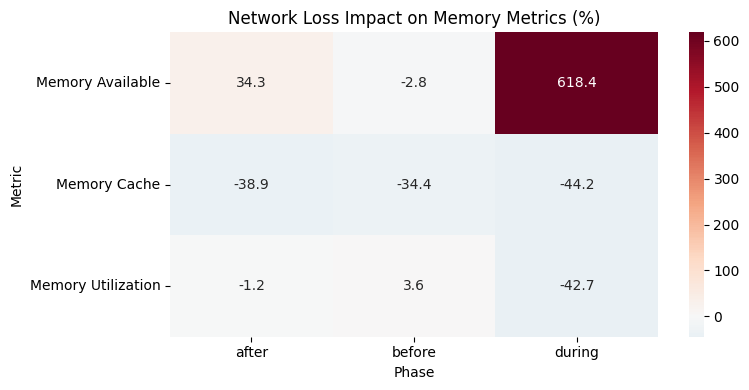


✅ Analysis Complete - Isolation Forest Network Loss Detection


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as scipy_stats
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Load datasets
df_mem_util = pd.read_csv("mem_util.csv")
df_mem_cache = pd.read_csv("mem_cache.csv")
df_mem_available = pd.read_csv("mem_available.csv")

df_baseline_mem_util = pd.read_csv("../../baseline/memory related/mem_util.csv")
df_baseline_mem_cache = pd.read_csv("../../baseline/memory related/mem_cache.csv")
df_baseline_mem_available = pd.read_csv("../../baseline/memory related/mem_available.csv")

# Add source labels
df_mem_util["source"] = "NETLOSS"
df_mem_cache["source"] = "NETLOSS"
df_mem_available["source"] = "NETLOSS"

df_baseline_mem_util["source"] = "BASELINE"
df_baseline_mem_cache["source"] = "BASELINE"
df_baseline_mem_available["source"] = "BASELINE"

# Convert to datetime
df_mem_util["Time"] = pd.to_datetime(df_mem_util["Time"])
df_mem_cache["Time"] = pd.to_datetime(df_mem_cache["Time"])
df_mem_available["Time"] = pd.to_datetime(df_mem_available["Time"])

df_baseline_mem_util["Time"] = pd.to_datetime(df_baseline_mem_util["Time"])
df_baseline_mem_cache["Time"] = pd.to_datetime(df_baseline_mem_cache["Time"])
df_baseline_mem_available["Time"] = pd.to_datetime(df_baseline_mem_available["Time"])

delay = 30
duration = 50

# Synchronize datasets
time_offset = df_baseline_mem_util["Time"].min() - df_mem_util["Time"].min()
df_mem_util["Time"] += time_offset
df_mem_cache["Time"] += time_offset
df_mem_available["Time"] += time_offset

# Convert to minutes
all_dfs = [
    df_mem_util, df_mem_cache, df_mem_available,
    df_baseline_mem_util, df_baseline_mem_cache, df_baseline_mem_available
]

for df in all_dfs:
    df["Minutes"] = (df["Time"] - df["Time"].min()).dt.total_seconds() / 60

# Dataset dictionary
datasets = {
    'Memory Utilization': {'netloss': df_mem_util, 'baseline': df_baseline_mem_util},
    'Memory Cache': {'netloss': df_mem_cache, 'baseline': df_baseline_mem_cache},
    'Memory Available': {'netloss': df_mem_available, 'baseline': df_baseline_mem_available}
}

# Isolation Forest outlier detection
def remove_outliers_isolation_forest(df, contamination=0.02):
    """Network loss optimized outlier detection"""
    df_clean = df.copy()
    
    numeric_cols = [col for col in df.select_dtypes(include=[np.number]).columns 
                   if col not in ['Time', 'Minutes']]
    
    if len(numeric_cols) == 0:
        return df_clean, {}
    
    if len(numeric_cols) == 1:
        main_col = numeric_cols[0]
        series = df[main_col].fillna(method='ffill').fillna(method='bfill')
        
        features = [series.values]
        
        if len(series) > 15:
            features.append(series.rolling(3, center=True).mean().fillna(method='ffill').fillna(method='bfill').values)
            features.append(series.rolling(7, center=True).mean().fillna(method='ffill').fillna(method='bfill').values)
            features.append(series.rolling(5, center=True).std().fillna(0).values)
            features.append(series.diff().fillna(0).values)
        
        feature_matrix = np.column_stack(features)
    else:
        feature_matrix = df[numeric_cols].fillna(method='ffill').fillna(method='bfill').values
    
    scaler = StandardScaler()
    feature_matrix_scaled = scaler.fit_transform(feature_matrix)
    
    iso_forest = IsolationForest(
        contamination=contamination,
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    )
    
    iso_forest.fit(feature_matrix_scaled)
    outlier_predictions = iso_forest.predict(feature_matrix_scaled)
    outlier_mask = outlier_predictions == -1
    
    for col in numeric_cols:
        df_clean.loc[outlier_mask, col] = np.nan
        df_clean[col] = df_clean[col].interpolate(method='linear')
    
    stats = {
        'total_outliers': outlier_mask.sum(),
        'contamination_rate': contamination
    }
    
    return df_clean, stats

# Apply outlier cleaning
print("Network Loss Memory Analysis - Isolation Forest Outlier Detection")
print("=" * 70)

datasets_clean = {}

for dataset_name, dataset_pair in datasets.items():
    print(f"\n📊 Processing {dataset_name}:")
    datasets_clean[dataset_name] = {}
    
    for source_type, df in dataset_pair.items():
        df_clean, stats = remove_outliers_isolation_forest(df, contamination=0.02)
        datasets_clean[dataset_name][source_type] = df_clean
        
        total_outliers = stats['total_outliers']
        print(f"  {source_type.upper()}: Cleaned {total_outliers} outliers")

# Normalization
def normalize_df(df, columns):
    result = df.copy()
    for col in columns:
        min_val = df[col].min()
        max_val = df[col].max()
        if max_val > min_val:
            result[col] = (df[col] - min_val) / (max_val - min_val)
        else:
            result[col] = 0
    return result

# Add phases
def add_phase_column(df, delay_minutes, duration_minutes):
    df = df.copy()
    df['phase'] = 'before'
    df.loc[(df['Minutes'] >= delay_minutes) & 
           (df['Minutes'] <= delay_minutes + duration_minutes), 'phase'] = 'during'
    df.loc[df['Minutes'] > delay_minutes + duration_minutes, 'phase'] = 'after'
    return df

# Analysis function
def analyze_dataset(dataset_name, netloss_df, baseline_df):
    numeric_cols = [col for col in netloss_df.select_dtypes(include=[np.number]).columns 
                   if col not in ['Time', 'Minutes']]
    
    if not numeric_cols:
        return None
    
    main_metric = numeric_cols[0]
    
    netloss_norm = normalize_df(netloss_df, numeric_cols)
    baseline_norm = normalize_df(baseline_df, numeric_cols)
    
    netloss_norm = add_phase_column(netloss_norm, delay, duration)
    baseline_norm = add_phase_column(baseline_norm, delay, duration)
    
    # Statistics
    stats_baseline = baseline_norm.groupby('phase')[main_metric].agg(['mean', 'std'])
    stats_netloss = netloss_norm.groupby('phase')[main_metric].agg(['mean', 'std'])
    
    # Combined data
    df_combined = pd.DataFrame({
        'Baseline': baseline_norm[main_metric],
        'NetLoss': netloss_norm[main_metric],
        'Minutes': baseline_norm['Minutes'],
        'phase': baseline_norm['phase'],
        'difference': netloss_norm[main_metric] - baseline_norm[main_metric]
    })
    
    # T-tests
    t_tests = {}
    impact = {}
    for phase in ['before', 'during', 'after']:
        data = df_combined[df_combined['phase'] == phase]
        t_stat, p_value = scipy_stats.ttest_ind(data['Baseline'].dropna(), data['NetLoss'].dropna())
        t_tests[phase] = {'t': t_stat, 'p': p_value}
        
        baseline_mean = stats_baseline.loc[phase, 'mean']
        netloss_mean = stats_netloss.loc[phase, 'mean']
        impact[phase] = ((netloss_mean - baseline_mean) / baseline_mean) * 100 if baseline_mean != 0 else 0
    
    # Plotting
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Original data
    original_baseline = datasets[dataset_name]['baseline']
    original_netloss = datasets[dataset_name]['netloss']
    
    # 1. Baseline cleaning
    axes[0,0].plot(original_baseline['Minutes'], original_baseline[main_metric], 
                   'orange', alpha=0.7, linewidth=1, label='Original')
    axes[0,0].plot(baseline_df['Minutes'], baseline_df[main_metric], 
                   'blue', linewidth=2, label='Cleaned')
    axes[0,0].set_title(f'{dataset_name}: Baseline Cleaning')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. NetLoss cleaning
    axes[0,1].plot(original_netloss['Minutes'], original_netloss[main_metric], 
                   'lightcoral', alpha=0.7, linewidth=1, label='Original')
    axes[0,1].plot(netloss_df['Minutes'], netloss_df[main_metric], 
                   'darkred', linewidth=2, label='Cleaned')
    axes[0,1].set_title(f'{dataset_name}: NetLoss Cleaning')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Comparison
    axes[0,2].plot(baseline_norm['Minutes'], baseline_norm[main_metric], 
                   'blue', linewidth=2, label='Baseline')
    axes[0,2].plot(netloss_norm['Minutes'], netloss_norm[main_metric], 
                   'red', linewidth=2, label='NetLoss')
    axes[0,2].axvspan(delay, delay + duration, color='red', alpha=0.2)
    axes[0,2].set_title(f'{dataset_name}: Comparison')
    axes[0,2].legend()
    axes[0,2].grid(True, alpha=0.3)
    
    # 4. Box plot
    box_data = pd.melt(df_combined[['Baseline', 'NetLoss', 'phase']], 
                      id_vars=['phase'], var_name='source', value_name='value')
    sns.boxplot(x='phase', y='value', hue='source', data=box_data, ax=axes[1,0])
    axes[1,0].set_title('Distribution by Phase')
    
    # 5. Phase statistics
    phases = ['before', 'during', 'after']
    x = np.arange(len(phases))
    width = 0.35
    
    axes[1,1].bar(x - width/2, stats_baseline['mean'], width, label='Baseline', alpha=0.8)
    axes[1,1].bar(x + width/2, stats_netloss['mean'], width, label='NetLoss', alpha=0.8)
    axes[1,1].set_xticks(x)
    axes[1,1].set_xticklabels(phases)
    axes[1,1].set_title('Mean by Phase')
    axes[1,1].legend()
    
    # 6. Difference
    axes[1,2].plot(df_combined['Minutes'], df_combined['difference'], 'purple', linewidth=2)
    axes[1,2].axhline(y=0, color='black', linestyle='-', alpha=0.5)
    axes[1,2].axvspan(delay, delay + duration, color='red', alpha=0.2)
    axes[1,2].set_title('NetLoss - Baseline Difference')
    axes[1,2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print results
    print(f"\n{dataset_name.upper()} RESULTS:")
    print("=" * 50)
    print(f"BASELINE STATS BY PHASE:")
    print(stats_baseline.round(4))
    print(f"\nNETLOSS STATS BY PHASE:")
    print(stats_netloss.round(4))
    print(f"\nSTATISTICAL TESTS:")
    for phase, test in t_tests.items():
        sig = "SIGNIFICANT" if test['p'] < 0.05 else "NOT SIGNIFICANT"
        print(f"  {phase.upper()}: t={test['t']:.2f}, p={test['p']:.4f} ({sig})")
    print(f"\nIMPACT (% CHANGE):")
    for phase, change in impact.items():
        print(f"  {phase.upper()}: {change:+.1f}%")
    
    return {
        'stats_baseline': stats_baseline,
        'stats_netloss': stats_netloss,
        't_tests': t_tests,
        'impact': impact
    }

# Run analysis
results = {}
for dataset_name in datasets_clean.keys():
    print(f"\n🔄 Analyzing {dataset_name}...")
    
    netloss_clean = datasets_clean[dataset_name]['netloss']
    baseline_clean = datasets_clean[dataset_name]['baseline']
    
    results[dataset_name] = analyze_dataset(dataset_name, netloss_clean, baseline_clean)

# Summary
print(f"\n{'='*80}")
print("NETWORK LOSS IMPACT SUMMARY")
print(f"{'='*80}")

summary_data = []
for dataset_name, result in results.items():
    if result:
        for phase in ['before', 'during', 'after']:
            summary_data.append({
                'Metric': dataset_name,
                'Phase': phase,
                'Impact (%)': f"{result['impact'][phase]:+.1f}%",
                'P-Value': f"{result['t_tests'][phase]['p']:.4f}",
                'Significant': 'YES' if result['t_tests'][phase]['p'] < 0.05 else 'NO'
            })

if summary_data:
    summary_df = pd.DataFrame(summary_data)